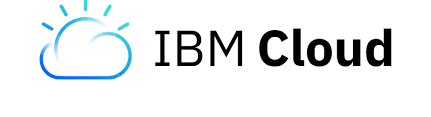

# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [33]:
import pyLDAvis
import pyLDAvis.lda_model

In [ ]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True

try:
    import pyLDAvis
    # import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
# plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

Exception: 'pip install pyldavis' before running this notebook

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [2]:
movie_reviews = load_files(os.path.join(DATA_DIR, "movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[4])

b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"


In [5]:
len(X)

2000

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [ ]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokensa if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

/home/diana/miniconda3/lib/python3.13/site-packages/pydantic/v1/typing.py:68: DeprecationWarning: Failing to pass a value to the 'type_params' parameter of 'typing.ForwardRef._evaluate' is deprecated, as it leads to incorrect behaviour when calling typing.ForwardRef._evaluate on a stringified annotation that references a PEP 695 type parameter. It will be disallowed in Python 3.15.
  return cast(Any, type_)._evaluate(globalns, localns, recursive_guard=set())
/home/diana/miniconda3/lib/python3.13/site-packages/pydantic/v1/typing.py:68: DeprecationWarning: Failing to pass a value to the 'type_params' parameter of 'typing.ForwardRef._evaluate' is deprecated, as it leads to incorrect behaviour when calling typing.ForwardRef._evaluate on a stringified annotation that references a PEP 695 type parameter. It will be disallowed in Python 3.15.
  return cast(Any, type_)._evaluate(globalns, localns, recursive_guard=set())
/home/diana/miniconda3/lib/python3.13/site-packages/pydantic/v1/typing.py:

Loading English Module...
fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [6]:
## YOUR CODE HERE

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.
processed = [lemmatize_document(doc, STOPLIST) for doc in X]
print("processing done.")

processing done.


In [7]:
len(processed)

2000

In [9]:
X[0] 

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [10]:
processed[0]

'barnold schwarzenegg icon action enthusiast late 80 lately sloppy oneliner bad hard seeing arnold mr freeze batman robin especially say ton ice joke hey 15 million matter arnold sign expensive blockbuster compare like terminator series true lie eraser dark thriller devil gabriel byrne come earth impregnate woman robin tunney happen 1000 year basically destroy world apparently god choose man man jericho cane arnold help trusty sidekick kevin pollack stop let devil world actually absurd fit right dogma yes weak blockbuster right sleepy hollow world look like star definitely like arnold just type sure chuckle know oneliner confused character understandable especially ending change accord source aside form walk like past sorry say arnold maybe end action day speak action hardly explosion fight devil place explode arnold kick devil butt ending change spiritual undoubtedly ruin hop cool ending occur let know long cost really super affect unless consider invisible devil minute worth overpric

### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the documents.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [11]:
## YOUR CODE HERE

max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features)

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


In [12]:
tf.shape

(2000, 500)

In [15]:
tf[0].toarray()

array([[0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        2, 0, 1, 0, 1, 7, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [18]:
## YOUR CODE HERE
n_topics = 10

# Create an LDA object
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

# Fit the model to the bag of word we created earlier
lda_model.fit(tf)

,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'online'
,learning_decay,0.7
,learning_offset,50.0
,max_iter,5
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [34]:
import pyLDAvis
import pyLDAvis.lda_model

vis = pyLDAvis.lda_model.prepare(
    lda_model, 
    tf, 
    tf_vectorizer
)
pyLDAvis.display(vis)


## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [37]:
## YOUR CODE HERE
import pyLDAvis.lda_model
# set the number of topics
n_topics = 7

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

# fit and transform the LDA model to the vecotrized corpus
lda_transformed = lda_model.fit_transform(tf)

# use the pyLDAvis to visualise the topics
vis = pyLDAvis.lda_model.prepare(
    lda_model, 
    tf, 
    tf_vectorizer
)
pyLDAvis.display(vis)


The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [ ]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

In [39]:
lda_model.components_

array([[2.74702309e+00, 3.00270409e+00, 1.88218351e+00, ...,
        8.56468864e-01, 3.06196784e-01, 8.77340689e+01],
       [9.29569881e+00, 4.47087474e+01, 1.48784494e+00, ...,
        7.42790305e+00, 4.50596340e-01, 6.71836341e+01],
       [1.41224242e+02, 2.96810265e+02, 8.70837373e+01, ...,
        3.06542384e+01, 4.08468068e+01, 3.70804561e+02],
       ...,
       [2.25292061e+01, 4.10003539e+01, 3.73472946e+01, ...,
        1.95546992e+01, 6.54863264e+00, 5.68728749e+01],
       [4.16935642e+01, 1.11376386e+02, 3.85747624e+01, ...,
        7.07805877e+01, 2.89779442e+01, 4.79672406e+01],
       [9.79125497e+01, 2.33920390e+02, 1.32730010e+02, ...,
        1.10572634e+02, 3.55810841e+01, 8.52372502e+01]], shape=(7, 500))

In [40]:
tf_vectorizer.get_feature_names_out()

array(['able', 'act', 'acting', 'action', 'actor', 'actress', 'actually',
       'add', 'age', 'agent', 'ago', 'alien', 'allow', 'america',
       'american', 'apparently', 'appear', 'approach', 'art', 'ask',
       'aspect', 'attack', 'attempt', 'attention', 'audience', 'away',
       'bad', 'base', 'basically', 'batman', 'battle', 'beautiful',
       'begin', 'beginning', 'believe', 'ben', 'big', 'bit', 'black',
       'body', 'book', 'boring', 'boy', 'break', 'bring', 'brother',
       'build', 'camera', 'car', 'care', 'career', 'carry', 'case',
       'cast', 'catch', 'cause', 'certain', 'certainly', 'chance',
       'change', 'character', 'chase', 'child', 'choose', 'chris', 'city',
       'classic', 'close', 'come', 'comedy', 'comic', 'complete',
       'completely', 'computer', 'consider', 'contain', 'cool', 'cop',
       'couple', 'course', 'cover', 'create', 'credit', 'crew', 'crime',
       'cut', 'dark', 'daughter', 'david', 'day', 'dead', 'deal', 'death',
       'decide', '

Use the function to print the top k words for each topic

In [41]:
## YOUR CODE HERE

## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = tf_vectorizer.get_feature_names_out()

## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)

## print the topics and the top words of each topic
for topic_id, words in top_words.items():
    print(f"Topic {topic_id}:")
    print(", ".join(words))
    print()


Topic 0:
disney, voice, ship, king, story, family, kid, child, little, computer, feature, song, young, studio, parent

Topic 1:
war, horror, scream, killer, know, ryan, character, summer, man, death, murder, year, george, save, time

Topic 2:
character, story, life, scene, good, like, play, time, man, love, performance, work, come, way, just

Topic 3:
new, city, like, vampire, book, american, character, use, play, action, time, joe, scene, york, man

Topic 4:
alien, star, effect, like, special, series, good, time, story, planet, year, character, look, original, space

Topic 5:
good, like, just, comedy, big, character, funny, time, really, play, thing, people, great, know, come

Topic 6:
like, bad, just, character, good, scene, time, know, think, look, thing, say, really, play, plot



## QUESTION (EXTRA CREDIT) 7

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

In [45]:
lda_transformed.shape

(2000, 7)

In [47]:
lda_transformed[0]

array([0.00127917, 0.00128128, 0.00128078, 0.00128058, 0.31344137,
       0.00128221, 0.68015462])

In [42]:
## YOUR CODE HERE
import numpy as np

# Get the dominant topic index per document
dominant_topic = np.argmax(lda_transformed, axis=1)

# Optional: filter only confident docs
confident_mask = np.max(lda_transformed, axis=1) > 0.5
dominant_topic_filtered = np.where(confident_mask, dominant_topic, -1)  # -1 = mixed topic

In [53]:
dominant_topic

array([6, 2, 5, ..., 2, 2, 2], shape=(2000,))

In [ ]:
confident_mask

array([ True,  True,  True, ...,  True,  True,  True], shape=(2000,))

In [52]:
dominant_topic_filtered

array([6, 2, 5, ..., 2, 2, 2], shape=(2000,))

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(lda_transformed)
X_pca.shape

(2000, 2)

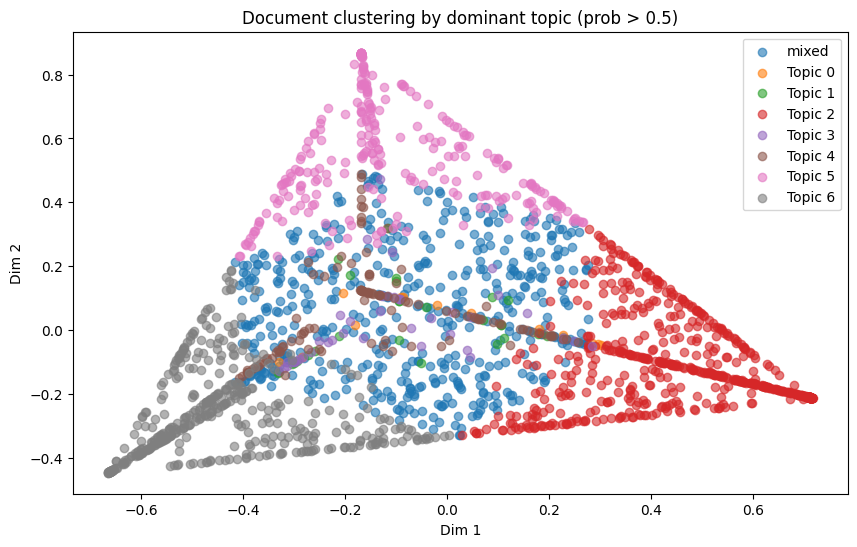

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Use PCA or t-SNE embeddings
embeddings = X_pca  # or X_tsne

# Plot each topic
for topic in np.unique(dominant_topic_filtered):
    if topic == -1:
        label = "mixed"
        color = "gray"
    else:
        label = f"Topic {topic}"
        color = f"C{topic}"  # matplotlib default color cycle

    mask = dominant_topic_filtered == topic
    plt.scatter(embeddings[mask,0], embeddings[mask,1], label=label, alpha=0.6)

plt.legend()
plt.title("Document clustering by dominant topic (prob > 0.5)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()
